# Topic: Partial Freezing of MLMs for PoS Tagging: A Case of Naija Pidgin

In [1]:
!pip -q install datasets transformers conllu torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.1 MB/s eta 0:00:00


# Task 1: Dataset Preparation and Baseline Model Training



## Loading Data

In [2]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import requests, zipfile, io, os

# GitHub raw URL (direct to the ZIP)
url = "https://github.com/johnemekaeze/PoS-Tagging-MLMs-Partial-Freezing/raw/main/data/ud-treebanks-v2.16-subset.zip"

# Download and extract to a folder
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall("ud_subset")  # this creates a folder with all sub-treebanks

In [4]:
import os

root_path = "ud_subset/ud-treebanks-v2.16-subset"
treebanks = sorted(os.listdir(root_path))
print("Available treebanks:")
treebanks

Available treebanks:


['UD_English-Atis',
 'UD_English-CHILDES',
 'UD_English-CTeTex',
 'UD_English-ESLSpok',
 'UD_English-EWT',
 'UD_English-GENTLE',
 'UD_English-GUM',
 'UD_English-GUMReddit',
 'UD_English-LinES',
 'UD_English-ParTUT',
 'UD_Hausa-NorthernAutogramm',
 'UD_Hausa-SouthernAutogramm',
 'UD_Naija-NSC',
 'UD_Yoruba-YTB']

In [5]:
from conllu import parse_incr

def load_conllu_sentences(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            tokens = [token["form"].lower() for token in tokenlist if type(token["id"]) == int]
            upos   = [token["upos"] for token in tokenlist if type(token["id"]) == int]
            data.append((tokens, upos))
    return data

In [6]:
tb_name = "UD_Naija-NSC"
train_path = os.path.join(root_path, tb_name, "pcm_nsc-ud-train.conllu")
test_path  = os.path.join(root_path, tb_name, "pcm_nsc-ud-test.conllu")
dev_path   = os.path.join(root_path, tb_name, "pcm_nsc-ud-dev.conllu")

train_sentences = load_conllu_sentences(train_path)
test_sentences  = load_conllu_sentences(test_path)
dev_sentences   = load_conllu_sentences(dev_path)

# Example
print(f"{len(train_sentences)} sentences loaded.")
print("Tokens:", train_sentences[0][0])
print("UPOS  :", train_sentences[0][1])


7279 sentences loaded.
Tokens: ['auntie', '<', 'good', 'morning', '//']
UPOS  : ['NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']


In [7]:
train_sentences[:10]

[(['auntie', '<', 'good', 'morning', '//'],
  ['NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']),
 (['good', 'morning', '!//'], ['ADJ', 'NOUN', 'PUNCT']),
 (['how', 'you', 'dey', 'now', '?//'],
  ['ADV', 'PRON', 'VERB', 'ADV', 'PUNCT']),
 (['i', 'dey', 'fine', '//'], ['PRON', 'VERB', 'ADJ', 'PUNCT']),
 (['how', 'your', 'night', '?//'], ['ADV', 'PRON', 'NOUN', 'PUNCT']),
 (['we', 'thank', 'god', '//'], ['PRON', 'VERB', 'PROPN', 'PUNCT']),
 (['hope', 'sey', '[', 'you', 'sleep', 'well', ']', '?//'],
  ['VERB', 'SCONJ', 'PUNCT', 'PRON', 'VERB', 'ADV', 'PUNCT', 'PUNCT']),
 (['ah', 'my', 'sister', '<', 'i', 'sleep', 'well', 'o', '!//'],
  ['INTJ', 'PRON', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'ADV', 'PART', 'PUNCT']),
 (['una', 'get', 'light', 'for', 'una', 'area', 'last', 'night', '?//'],
  ['PRON', 'VERB', 'NOUN', 'ADP', 'PRON', 'NOUN', 'ADJ', 'NOUN', 'PUNCT']),
 (['we', 'no', 'get', 'o', '//'], ['PRON', 'AUX', 'VERB', 'PART', 'PUNCT'])]

In [8]:
print(f"Number of training examples: {len(train_sentences)}")
print(f"Number of test examples: {len(test_sentences)}")
print(f"Number of dev examples: {len(dev_sentences)}")

Number of training examples: 7279
Number of test examples: 972
Number of dev examples: 990


## Tokenization

In [46]:
import random

# Set seed for reproducibility
random.seed(42)

train_subset = train_sentences #random.sample(train_sentences, int(0.2 * len(train_sentences)))
dev_subset   = dev_sentences #random.sample(dev_sentences,   int(0.2 * len(dev_sentences)))
test_subset  = test_sentences #random.sample(test_sentences,  int(0.2 * len(test_sentences)))

In [47]:
# Get full set of UPOS tags from training split
all_tags = sorted({tag for _, tags in train_subset for tag in tags})
tag2id = {tag: i for i, tag in enumerate(all_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

In [48]:
from transformers import AutoTokenizer

# Load a multilingual DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

def tokenize_and_align(example, label_all_tokens=False):
    tokens, labels = example
    tokenized = tokenizer(tokens,
                          is_split_into_words=True,
                          truncation=True,
                          max_length=128)

    word_ids = tokenized.word_ids()
    aligned_labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)
        elif word_idx != previous_word_idx:
            aligned_labels.append(tag2id[labels[word_idx]])
        else:
            aligned_labels.append(tag2id[labels[word_idx]] if label_all_tokens else -100)
        previous_word_idx = word_idx

    tokenized["labels"] = aligned_labels
    return tokenized


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [49]:
from datasets import Dataset

# Wrap into HuggingFace Datasets
train_dataset = Dataset.from_list([{"tokens": t, "upos": u} for t, u in train_subset])
dev_dataset   = Dataset.from_list([{"tokens": t, "upos": u} for t, u in dev_subset])
test_dataset  = Dataset.from_list([{"tokens": t, "upos": u} for t, u in test_subset])

# Tokenize and align
train_tok = train_dataset.map(lambda ex: tokenize_and_align((ex["tokens"], ex["upos"])),
                              batched=False)
dev_tok   = dev_dataset.map(lambda ex: tokenize_and_align((ex["tokens"], ex["upos"])),
                            batched=False)
test_tok  = test_dataset.map(lambda ex: tokenize_and_align((ex["tokens"], ex["upos"])),
                             batched=False)

Map:   0%|          | 0/7279 [00:00<?, ? examples/s]

Map:   0%|          | 0/990 [00:00<?, ? examples/s]

Map:   0%|          | 0/972 [00:00<?, ? examples/s]

In [50]:
print("Original Tokens:", train_subset[0][0])
print("Tokenized Version:", tokenizer.convert_ids_to_tokens(train_tok[0]["input_ids"]))
print("Labels:", [id2tag[label] if label != -100 else -100 for label in train_tok[0]["labels"]])

Original Tokens: ['auntie', '<', 'good', 'morning', '//']
Tokenized Version: ['[CLS]', 'aun', '##tie', '<', 'good', 'morning', '/', '/', '[SEP]']
Labels: [-100, 'NOUN', -100, 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', -100, -100]


## Fine-tuning a Distilled Model (Baseline)

In [51]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")


# 2) Load tokenizer & model
model_name = "distilbert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label={i: t for t, i in tag2id.items()},
    label2id=tag2id,
)

# 3) Data collator to pad and align labels
data_collator = DataCollatorForTokenClassification(tokenizer)

# 4) Define metrics function (here: token accuracy)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    # only consider non -100 labels
    mask = labels != -100
    acc = (preds[mask] == labels[mask]).astype(np.float32).mean().item()
    return {"accuracy": acc}

# 5) Training arguments
training_args = TrainingArguments(
    output_dir="./baseline_distilbert",
    eval_strategy="epoch",      # skip eval for the fastest baseline
    save_strategy="no",            # skip checkpointing
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)

# 6) Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 7) Train!
trainer.train()


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: johneze (john-eze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.089300,0.082152,0.977695
2,0.061500,0.072785,0.980372
3,0.028400,0.074018,0.982294
4,0.016700,0.074990,0.981950
5,0.013100,0.080084,0.982431


TrainOutput(global_step=2275, training_loss=0.06768661073275975, metrics={'train_runtime': 388.309, 'train_samples_per_second': 93.727, 'train_steps_per_second': 5.859, 'total_flos': 541821045324384.0, 'train_loss': 0.06768661073275975, 'epoch': 5.0})

In [52]:
# Baseline evaluation on a small dev split
metrics = trainer.evaluate(eval_dataset=dev_tok)
print("Evaluation accuracy:", metrics["eval_accuracy"])

Evaluation accuracy: 0.9824308753013611


# Task 2: Model Adjustment and Partial Freezing




## Layer Freezing

In [53]:
from transformers import AutoModelForTokenClassification

def freeze_layers(model, freeze_strategy="first_k", k=2):
    """
    Freeze layers of a DistilBERT model based on the given strategy.

    Args:
        model: An instance of AutoModelForTokenClassification based on DistilBERT.
        freeze_strategy: Strategy to freeze layers. Options:
            - "all_encoder": Freeze all encoder layers.
            - "first_k": Freeze the first k encoder layers.
            - "last_k": Freeze the last k encoder layers.
            - "alternating": Freeze alternating layers (even-indexed).
        k: Number of layers to freeze for "first_k" or "last_k" strategies.
    """


    layers = model.distilbert.transformer.layer

    if freeze_strategy == "all_encoder":
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

    elif freeze_strategy == "first_k":
        for i, layer in enumerate(layers):
            if i < k:
                for param in layer.parameters():
                    param.requires_grad = False

    elif freeze_strategy == "alternating":
        for i, layer in enumerate(layers):
            if i % 2 == 0:
                for param in layer.parameters():
                    param.requires_grad = False
    else:
        raise ValueError(f"Unknown freeze_strategy: {freeze_strategy}")

In [54]:
model.distilbert.transformer.layer

ModuleList(
  (0-5): 6 x TransformerBlock(
    (attention): DistilBertSdpaAttention(
      (dropout): Dropout(p=0.1, inplace=False)
      (q_lin): Linear(in_features=768, out_features=768, bias=True)
      (k_lin): Linear(in_features=768, out_features=768, bias=True)
      (v_lin): Linear(in_features=768, out_features=768, bias=True)
      (out_lin): Linear(in_features=768, out_features=768, bias=True)
    )
    (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (ffn): FFN(
      (dropout): Dropout(p=0.1, inplace=False)
      (lin1): Linear(in_features=768, out_features=3072, bias=True)
      (lin2): Linear(in_features=3072, out_features=768, bias=True)
      (activation): GELUActivation()
    )
    (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  )
)

In [55]:
len(model.distilbert.transformer.layer)

6

## Freeze all encoder layers

In [56]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")


# 2) Load tokenizer & model
model_name = "distilbert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label={i: t for t, i in tag2id.items()},
    label2id=tag2id,
)

# 3) Apply partial-freeze
freeze_layers(model, freeze_strategy="all_encoder")

# 4) Prepare data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# 5) Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    mask = labels != -100
    acc = (preds[mask] == labels[mask]).astype(np.float32).mean().item()
    return {"accuracy": acc}

# 6) Training arguments
training_args = TrainingArguments(
    output_dir="./frozen_first_2_distilbert",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)

# 7) Initialize Trainer with the already‑frozen model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,             # now you can also evaluate each epoch
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 8) Train!
trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.923000,0.789293,0.829662
2,0.463600,0.389504,0.904193
3,0.318700,0.289957,0.923890
4,0.273500,0.252709,0.930341
5,0.273400,0.242980,0.932263


TrainOutput(global_step=2275, training_loss=0.6158748027256556, metrics={'train_runtime': 196.1272, 'train_samples_per_second': 185.568, 'train_steps_per_second': 11.6, 'total_flos': 541821045324384.0, 'train_loss': 0.6158748027256556, 'epoch': 5.0})

In [57]:
# 8) Baseline evaluation on a small dev split
metrics = trainer.evaluate(eval_dataset=dev_tok)
print("Evaluation accuracy:", metrics["eval_accuracy"])

Evaluation accuracy: 0.9322627186775208


## Freeze first 2 layers

In [58]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")


# 2) Load tokenizer & model
model_name = "distilbert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label={i: t for t, i in tag2id.items()},
    label2id=tag2id,
)

# 3) Apply partial-freeze
freeze_layers(model, freeze_strategy="first_k", k=2)

# 4) Prepare data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# 5) Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    mask = labels != -100
    acc = (preds[mask] == labels[mask]).astype(np.float32).mean().item()
    return {"accuracy": acc}

# 6) Training arguments
training_args = TrainingArguments(
    output_dir="./frozen_first_2_distilbert",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)

# 7) Initialize Trainer with the already‑frozen model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,             # now you can also evaluate each epoch
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 8) Train!
trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.097600,0.090729,0.974950
2,0.068800,0.078094,0.978656
3,0.037300,0.083517,0.978931
4,0.021000,0.080185,0.980646
5,0.017000,0.082884,0.981264


TrainOutput(global_step=2275, training_loss=0.07960525478635515, metrics={'train_runtime': 249.6293, 'train_samples_per_second': 145.796, 'train_steps_per_second': 9.114, 'total_flos': 541821045324384.0, 'train_loss': 0.07960525478635515, 'epoch': 5.0})

In [59]:
# 8) Baseline evaluation on a small dev split
metrics = trainer.evaluate(eval_dataset=dev_tok)
print("Evaluation accuracy:", metrics["eval_accuracy"])

Evaluation accuracy: 0.9812641739845276


## Freeze first 4 layers

In [60]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")


# 2) Load tokenizer & model
model_name = "distilbert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label={i: t for t, i in tag2id.items()},
    label2id=tag2id,
)

# 3) Apply partial-freeze
freeze_layers(model, freeze_strategy="first_k", k=4)

# 4) Prepare data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# 5) Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    mask = labels != -100
    acc = (preds[mask] == labels[mask]).astype(np.float32).mean().item()
    return {"accuracy": acc}

# 6) Training arguments
training_args = TrainingArguments(
    output_dir="./frozen_first_4_distilbert",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)

# 7) Initialize Trainer with the already‑frozen model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,             # now you can also evaluate each epoch
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 8) Train!
trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.130700,0.113666,0.966372
2,0.091700,0.091639,0.973578
3,0.056500,0.090377,0.975225
4,0.039900,0.089033,0.976117
5,0.036200,0.087311,0.977078


TrainOutput(global_step=2275, training_loss=0.11099234070096697, metrics={'train_runtime': 223.5484, 'train_samples_per_second': 162.806, 'train_steps_per_second': 10.177, 'total_flos': 541821045324384.0, 'train_loss': 0.11099234070096697, 'epoch': 5.0})

In [61]:
# Baseline evaluation on a small dev split
dev_hf = dev_tok
metrics = trainer.evaluate(eval_dataset=dev_hf)
print("Evaluation accuracy:", metrics["eval_accuracy"])

Evaluation accuracy: 0.9770777821540833


## Alternate freezing strategy

In [62]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")


# Load tokenizer & model
model_name = "distilbert-base-multilingual-cased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label={i: t for t, i in tag2id.items()},
    label2id=tag2id,
)

# Apply partial-freeze
freeze_layers(model, freeze_strategy="alternating")

# Prepare data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids
    mask = labels != -100
    acc = (preds[mask] == labels[mask]).astype(np.float32).mean().item()
    return {"accuracy": acc}

# Training arguments
training_args = TrainingArguments(
    output_dir="./frozen_alt_distilbert",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)

# Initialize Trainer with the already‑frozen model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.100300,0.090939,0.973989
2,0.071100,0.074628,0.978794
3,0.038700,0.076613,0.979754
4,0.027100,0.076771,0.980784
5,0.022800,0.078143,0.982294


TrainOutput(global_step=2275, training_loss=0.08658811562663907, metrics={'train_runtime': 236.4821, 'train_samples_per_second': 153.902, 'train_steps_per_second': 9.62, 'total_flos': 541821045324384.0, 'train_loss': 0.08658811562663907, 'epoch': 5.0})

In [63]:
# 8) Baseline evaluation on a small dev split
dev_hf = dev_tok
metrics = trainer.evaluate(eval_dataset=dev_hf)
print("Evaluation accuracy:", metrics["eval_accuracy"])

Evaluation accuracy: 0.9822936058044434


# Task 3: Analysis and Comparison

## Analysis of Parameters

In [64]:
import torch
from transformers import AutoModelForTokenClassification
import pandas as pd

# Define freeze function
def freeze_layers(model, strategy, k=0):
    # Unfreeze all first
    for param in model.parameters():
        param.requires_grad = True
    layers = model.distilbert.transformer.layer
    if strategy == "all_encoder":
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False
    elif strategy == "first_k":
        for i, layer in enumerate(layers):
            if i < k:
                for param in layer.parameters():
                    param.requires_grad = False
    elif strategy == "alternating":
        for i, layer in enumerate(layers):
            if i % 2 == 0:
                for param in layer.parameters():
                    param.requires_grad = False

# Load base model name
model_name = "distilbert-base-multilingual-cased"
strategies = [
    ("No Freeze", None, 0),
    ("Freeze All", "all_encoder", 0),
    ("Freeze First 2", "first_k", 2),
    ("Freeze First 4", "first_k", 4),
    ("Alternating Freeze", "alternating", 0),
]

results = []

for name, strat, k in strategies:
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, num_labels=10  # dummy num_labels
    )
    if strat:
        freeze_layers(model, strat, k)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    results.append({
        "Strategy": name,
        "Total Params": total_params,
        "Trainable Params": trainable_params,
        "Trainable (%)": trainable_params / total_params * 100
    })

df_params = pd.DataFrame(results)

# Display the DataFrame to the user
display(df_params)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not ini

,Strategy,Total Params,Trainable Params,Trainable (%)
0,No Freeze,134741770,134741770,100.000000
1,Freeze All,134741770,92214538,68.437974
2,Freeze First 2,134741770,120566026,89.479325
3,Freeze First 4,134741770,106390282,78.958650
4,Alternating Freeze,134741770,113478154,84.218987


## Model Performance Across Freezing Strategies

,Strategy,Dev Accuracy
0,Baseline,98.2
1,Freeze All,93.2
2,Freeze First 2,98.1
3,Freeze First 4,97.7
4,Alternating Freeze,98.2


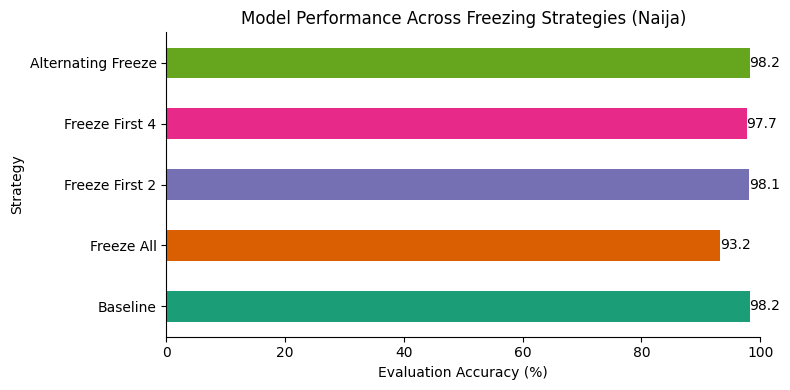

In [67]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Example results - replace with your actual evaluation metrics
data = {
    "Strategy": ["Baseline", "Freeze All", "Freeze First 2", "Freeze First 4", "Alternating Freeze"],
    "Dev Accuracy": [98.2, 93.2, 98.1, 97.7, 98.2]
}
df_results = pd.DataFrame(data)

# Display the DataFrame to the user
display(df_results)

# Create horizontal bar chart with Dark2 palette
palette = sns.color_palette("Dark2", n_colors=len(df_results))
plt.figure(figsize=(8, 4))
ax = df_results.set_index('Strategy')['Dev Accuracy'].plot(
    kind='barh',
    color=palette
)

# Annotate each bar with its accuracy value
for i, (strategy, accuracy) in enumerate(zip(df_results['Strategy'], df_results['Dev Accuracy'])):
    ax.text(accuracy + 0.005, i, f"{accuracy:.1f}", va='center')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Evaluation Accuracy (%)")
plt.title("Model Performance Across Freezing Strategies (Naija)")
plt.xlim(0, 100.0)  # ensure space for labels on the right
plt.tight_layout()
plt.show()


## Epoch Convergence Curve

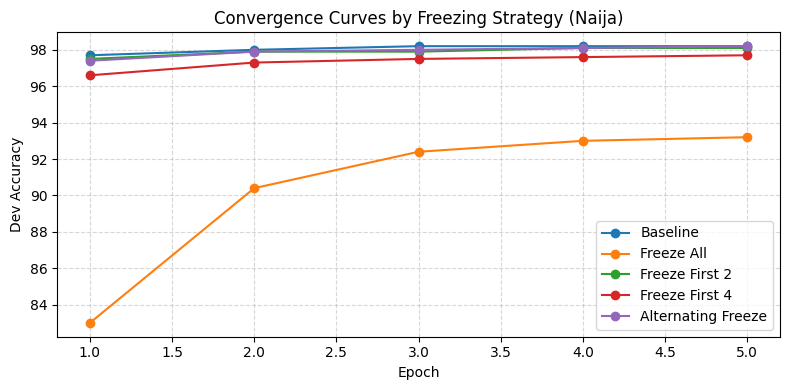

In [71]:
import matplotlib.pyplot as plt

# Example: histories is a dict mapping strategy → list of accuracies per epoch
histories = {
    "Baseline":           [97.7, 98.0, 98.2, 98.2, 98.2],
    "Freeze All":         [83.0, 90.4, 92.4, 93.0, 93.2],
    "Freeze First 2":     [97.5, 97.9, 97.9, 98.1, 98.1],
    "Freeze First 4":     [96.6, 97.3, 97.5, 97.6, 97.7],
    "Alternating Freeze": [97.4, 97.9, 98.0, 98.1, 98.2],
}

plt.figure(figsize=(8,4))
for strat, accs in histories.items():
    plt.plot(range(1, len(accs)+1), accs, marker='o', label=strat)
plt.xlabel("Epoch")
plt.ylabel("Dev Accuracy")
plt.title("Convergence Curves by Freezing Strategy (Naija)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Accuracy vs Model Size Trade-off

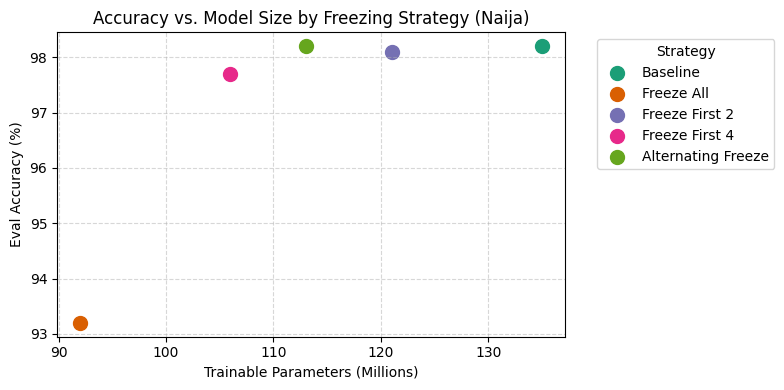

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data — replace with your actual numbers
param_counts = {
    "Baseline":           135,
    "Freeze All":           92,
    "Freeze First 2":       121,
    "Freeze First 4":       106,
    "Alternating Freeze":   113,
}
accuracies = {
    "Baseline":           98.2,
    "Freeze All":          93.2,
    "Freeze First 2":      98.1,
    "Freeze First 4":      97.7,
    "Alternating Freeze":  98.2,
}

# Create a consistent color palette
palette = sns.color_palette("Dark2", n_colors=len(param_counts))

plt.figure(figsize=(8, 4))
for (strategy, count), color in zip(param_counts.items(), palette):
    plt.scatter(count, accuracies[strategy], s=100, color=color, label=strategy)

plt.xlabel("Trainable Parameters (Millions)")
plt.ylabel("Eval Accuracy (%)")
plt.title("Accuracy vs. Model Size by Freezing Strategy (Naija)")
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend instead of inline labels
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Training Time Saving

,Strategy,Training Time (seconds)
0,Baseline,388
1,Freeze All,196
2,Freeze First 2,249
3,Freeze First 4,223
4,Alternating Freeze,236


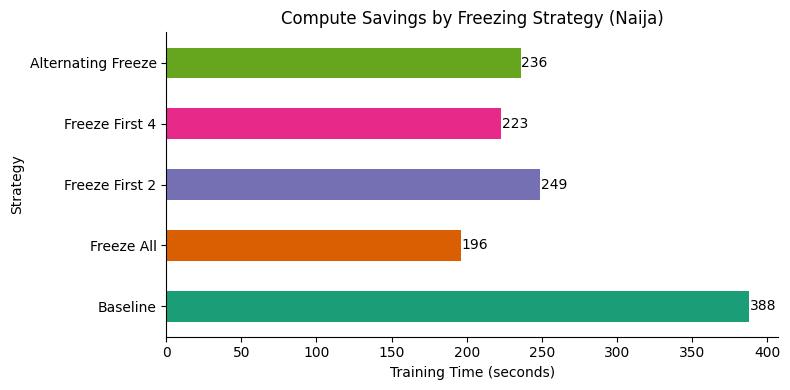

In [70]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Example training times - replace with your actual timing metrics
data = {
    "Strategy": ["Baseline", "Freeze All", "Freeze First 2", "Freeze First 4", "Alternating Freeze"],
    "Training Time (seconds)": [388, 196, 249, 223, 236]
}
df_times = pd.DataFrame(data)

# Display the DataFrame to the user
display(df_times)

# Create horizontal bar chart with Dark2 palette
palette = sns.color_palette("Dark2", n_colors=len(df_times))
plt.figure(figsize=(8, 4))
ax = df_times.set_index('Strategy')['Training Time (seconds)'].plot(
    kind='barh',
    color=palette
)

# Annotate each bar with its training time value
for i, (strategy, time_val) in enumerate(zip(df_times['Strategy'], df_times['Training Time (seconds)'])):
    ax.text(time_val + 0.5, i, f"{time_val:.0f}", va='center')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Training Time (seconds)")
plt.title("Compute Savings by Freezing Strategy (Naija)")
plt.tight_layout()
plt.show()

## Result Summary

In [72]:
import pandas as pd

# 1) Raw experiment metrics
data = {
    "Strategy": [
        "Baseline",
        "Freeze All",
        "Freeze First 2",
        "Freeze First 4",
        "Alternating Freeze"
    ],
    "Dev Accuracy (%)": [
        98.2,  # Baseline
        93.2,  # Freeze All
        98.1,  # Freeze First 2
        97.7,  # Freeze First 4
        98.2   # Alternating Freeze
    ],
    "Trainable Params (M)": [
        134,  # Baseline
        92,   # Freeze All
        120,  # Freeze First 2
        106,  # Freeze First 4
        113   # Alternating Freeze
    ],
    "Training Time (s)": [
        388,  # Baseline
        196,  # Freeze All
        249,  # Freeze First 2
        223,  # Freeze First 4
        236   # Alternating Freeze
    ]
}

# 2) Build DataFrame
df = pd.DataFrame(data)

# 3) Compute savings (%) relative to baseline time
baseline_time = df.loc[df["Strategy"] == "Baseline", "Training Time (s)"].iloc[0]
df["Compute Savings (%)"] = (
    (baseline_time - df["Training Time (s)"]) / baseline_time * 100
).round(1)

# 4) Rearrange columns for readability
df = df[[
    "Strategy",
    "Dev Accuracy (%)",
    "Trainable Params (M)",
    "Training Time (s)",
    "Compute Savings (%)"
]]

# 5) Display as markdown table (or use display(df) in a notebook)
print(df.to_markdown(index=False))


| Strategy           |   Dev Accuracy (%) |   Trainable Params (M) |   Training Time (s) |   Compute Savings (%) |
|:-------------------|-------------------:|-----------------------:|--------------------:|----------------------:|
| Baseline           |               98.2 |                    134 |                 388 |                   0   |
| Freeze All         |               93.2 |                     92 |                 196 |                  49.5 |
| Freeze First 2     |               98.1 |                    120 |                 249 |                  35.8 |
| Freeze First 4     |               97.7 |                    106 |                 223 |                  42.5 |
| Alternating Freeze |               98.2 |                    113 |                 236 |                  39.2 |
